In [5]:
using Random
using LinearAlgebra
using Statistics
using Plots
import Base.isless

using Cxx, Libdl

In [ ]:
const path_to_lib = pwd()
addHeaderDir(path_to_lib*"/world/", kind=C_System)
cxxinclude("runWorld.h")

In [ ]:
mutable struct Bird
    genes::Array{Float64}
    fitness::Float64
end

function Bird(;dim=5)
    genes = randn(dim)
    fitness = 0.0
    Bird(genes, fitness)
end 

function isless(b1::Bird, b2::Bird)
    b1.fitness < b2.fitness
end

In [ ]:
#test
flappy = Bird()
println(flappy)

In [ ]:
cxx"""

static double evaluate_bird(float g1, float g2, float g3, float g4, float g5) {
float ind[5] = {g1,g2,g3,g4,g5};

	const int NRUN = 3;
	auto &g = ind;
	double d = 0;
	for (int r = 0; r < NRUN; ++r) {
		World world;
		world.gen.seed(r * 100);
		while (world.bestiau.vivant) {

            world.update();
            // update inputs
            float birdY = world.bestiau.y;
            float birdVY = world.bestiau.vit;
            float obsX;
            float obsY;
            if (world.obstacles.size() > 0) {
                const auto &o = world.obstacles.front();
                obsY = o.y + world.hauteurPassage * 0.5;
                obsX = o.x / world.W;
            } else {
                obsY = world.H * 0.5;
                obsX = 1000.0;
            }
            double dd = world.dist;
            //if ((g[0]*birdY+g[1]*birdVY+g[2]*obsX+g[3]*obsY)>1.0) world.bestiauUp();
            //if ((g[0]*(birdY-obsY)+g[1]*birdY+g[2]*obsX+g[3]*birdVY)>1.0) world.bestiauUp();
            //if ((g[0]*(birdY-obmsY)+g[1]*birdY+g[2]*obsX+g[3]*birdVY+g[4]*dd)>1.0) world.bestiauUp();
            if ((g[0]*(birdY-obsY)+g[1]*birdY+g[2]*obsX+g[3]*birdVY+g[4]*world.vitesseDefilement)>1.0) world.bestiauUp();
        }
        d += world.dist;
        d -= 0.001*abs(world.bestiau.y-world.obstacles.front().y);
    }
    return d;
}
"""

In [ ]:
cpptojulia(g1::Float64, g2::Float64, g3::Float64, g4::Float64, g5::Float64) = @cxx evaluate_bird(g1,g2,g3,g4,g5)
function evaluate_bird(g::Array{Float64})
    cpptojulia(g[1],g[2],g[3],g[4],g[5])
end

In [7]:
function evaluate!(flappy::Bird)
    g=flappy.genes
    flappy.fitness = evaluate_bird(g)
end

evaluate! (generic function with 1 method)

In [8]:
# test

flappy = Bird()
println(flappy)
g = flappy.genes
ev = evaluate_bird(g)
println(ev)
evaluate!(flappy)
println(flappy)

println("_____2nd______")
flappy2 = Bird()
flappy2.genes = [-3.72, -0.46, -0.227, -1.90, 0.0] #param pour {deltaY, bY, oX, bVY} >1.0
println(flappy2)
ev2 = evaluate_bird(flappy2.genes)
println(ev2)
evaluate!(flappy2)
println(flappy2)


println("isless ", flappy>flappy2)
println("isless ", flappy<flappy2)



Bird([0.2622793562854866, 0.633446967742429, 0.6305322892650664, -1.0543301119654822, 1.4463478000389243], 0.0)
0.6082772753933049
Bird([0.2622793562854866, 0.633446967742429, 0.6305322892650664, -1.0543301119654822, 1.4463478000389243], 0.6082772753933049)
_____2nd______
Bird([-3.72, -0.46, -0.227, -1.9, 0.0], 0.0)
310.75271993426566
Bird([-3.72, -0.46, -0.227, -1.9, 0.0], 310.75271993426566)
isless false
isless true




#  _________________________ES 1___




In [9]:
function step_birds(best::Array{Float64};dim=5, npop=50, sigma=0.1, alpha=sigma/10)
    N = randn(npop,dim)
    P = repeat(best, 1, npop)' .+  sigma.* N #[N[i,:].*sigma for i in 1:npop]

    R = zeros(npop)
    for i in eachindex(R)
        R[i] = objective(P[i, :]) #evaluation
    end
    
    
    #println("  R    :", R)
    
    A = (R .- mean(R)) ./ std(R)
    #println("____________________")
    #println(" A :", A)
    #println("____________________")
    #println(" N : ", N[:,1])
    
    test = dot(N[:, 1], A)
    #println(" test :", test)
    if isnan(test)
        println("failed")
    end
    mat = [dot(N[:, i], A) for i in 1:size(N, 2)]
    #println("mat : ", mat)
    #println(alpha/(npop * sigma) .* mat)
    w = alpha/(npop * sigma) .* mat#[dot(N[:, i], A) for i in 1:size(N, dim)]
    #println(" w : ", w)
    best = best .+ w #modification step: changing the center of gravity
    best
end

step_birds (generic function with 1 method)

In [10]:
function run_es_bird(;Nstep=500, Npop=100, Sigma=0.1)
    dim = 5
    #best = randn(dim)
    #best = [-4.991793690362872, -1.0548510731723693, -0.46613776158659587, -2.281903602732939, -0.0011843804167953435]
    best = [-3.7801608774814435, -0.3807797572729434, -0.1904445735415997, -2.0321882891336522, -0.067457035171137]
    
    println("best initial: ", best)
    first_fitness = evaluate_bird(best)
    println("best initial fitness:", first_fitness)
    
    dist = zeros(Nstep)
    for i in 1:Nstep
        best = step_birds(best, dim=dim, npop=Npop, sigma=Sigma)
        #println("best: ", best)
        #println("best norm: ", norm(best))
        #println("dist max :" , objective(best))
        dist[i] = objective(best)
        #if dist[i]>300
         #   Sigma = 0.01
        #end
    end
    println("best final: ", best)
    println("best final dist: ", objective(best))
    #best
    dist
end

run_es_bird (generic function with 1 method)

In [ ]:
objective = evaluate_bird
Npop = 1000
Ngen = 100
sig = 0.1
res = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sig)
distances = res
plot(distances)
xaxis!("Ngen")
yaxis!("distance")
title!("Evolution de la fitness pour l'ES")

In [ ]:
objective = evaluate_bird
Npop = 200
Ngen = 500
sig = 0.001
res = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sig)
distances = res
plot(distances,legend=:outertopright)
xaxis!("Ngen")
yaxis!("distance")
title!("Evolution de la fitness pour l'ES")

for i in 1:10
    res = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sig)
    distances = res
    plot!(distances)
end

current()

#####avec Npop = 200, Ngen = 500, sig = 0.1
#best initial: [0.19507200551351175, -0.08498603878178577, 0.9501283764216036, 0.20293169509199305, 0.9760144556650499]
#best initial fitness:0.29995407539330476
#best final: [-3.7801608774814435, -0.3807797572729434, -0.1904445735415997, -2.0321882891336522, -0.067457035171137]
#best final dist: 358.579500125548

# ___ ES __ 1 __ Cumulatif

In [ ]:
function run_es_bird_cumu(;Nstep=500, Npop=100, Sigma=0.1)
    dim = 5
    
    best = randn(dim)
    #best = [-4.991793690362872, -1.0548510731723693, -0.46613776158659587, -2.281903602732939, -0.0011843804167953435]
    #best = [-3.7801608774814435, -0.3807797572729434, -0.1904445735415997, -2.0321882891336522, -0.067457035171137]
    
    
    println("best initial: ", best)
    first_fitness = evaluate_bird(best)
    println("best initial fitness:", first_fitness)
    cumul_fitness = first_fitness
    
    dist = zeros(Nstep)
    for i in 1:Nstep
        best = step_birds(best, dim=dim, npop=Npop, sigma=Sigma)

        if (objective(best) > cumul_fitness)
            cumul_fitness = objective(best)
        end
        
        dist[i] = cumul_fitness

    end
    println("best final: ", best)
    println("best final dist: ", objective(best))
    #best
    dist
end

In [ ]:
objective = evaluate_bird
Npop = 200
Ngen = 500
sig = 0.01

res = run_es_bird_cumu(Nstep=Ngen, Npop=Npop, Sigma=sig)
distances = res
plot(distances,legend=:outertopright)
xaxis!("Ngen")
yaxis!("distance")
title!("Evolution de la fitness pour l'ES")

for i in 1:5
    res = run_es_bird_cumu(Nstep=Ngen, Npop=Npop, Sigma=sig)
    distances = res
    plot!(distances)
end

current()

#####avec Npop = 200, Ngen = 500, sig = 0.1
#best initial: [0.19507200551351175, -0.08498603878178577, 0.9501283764216036, 0.20293169509199305, 0.9760144556650499]
#best initial fitness:0.29995407539330476
#best final: [-3.7801608774814435, -0.3807797572729434, -0.1904445735415997, -2.0321882891336522, -0.067457035171137]
#best final dist: 358.579500125548




#  _________________________ES________________




In [ ]:
mutable struct Obj_es
    center::Bird
    best::Array{Bird}
end

function Obj_es(;mu=5)
    center = Bird()
    evaluate!(center)
    best = Array{Bird}(undef, mu)
    for i in eachindex(best)
        best[i] = Bird()
        evaluate!(best[i])
    end
    Obj_es(center, best)
end 

In [ ]:
function es_step!(obj::Obj_es; npop=50, sigma=0.01, alpha=sigma/10)
    x = obj.center
    best = obj.best
    
    mu = length(best)
    #dim = length(Bird)
    #println(mu)
    #println(dim)
    dim=5
    
    N = randn(npop,dim) 
    Pop = Array{Bird}(undef, npop)
    R = zeros(npop)
    for i in eachindex(N[1:npop-mu,1])
        Pop[i] = Bird()
        Pop[i].genes = x.genes .+ sigma .* N[i]
        evaluate!(Pop[i])
        R[i] = Pop[i].fitness
    end
    for i in eachindex(best)
        Pop[npop-mu+i] = Bird()
        Pop[npop-mu+i] = best[i]
        R[npop-mu+i] = best[i].fitness
        
        N[npop-mu+i,:] = (best[i].genes-x.genes)./sigma
    end
    
    #println("_____________________")
    #for i in eachindex(Pop)
    #    print("   ",Pop[i].fitness)
    #end
    
    Pop2 = sort(Pop, rev=true)
        
    #println("_____________________")
    #for i in eachindex(Pop2)
    #    print("   ",Pop2[i].fitness)
    #end
    #println("_____________________")
    
    #println("  R    :", R)
    
    A = (R .- mean(R)) ./ std(R)
    #println("____________________")
    #println(" A :", A)
    #println("____________________")
    #println(" N : ", N[:,1])
    
    test = dot(N[:, 1], A)
    #println(" test :", test)
    if isnan(test)
        println("failed")
    end
    mat = [dot(N[:, i], A) for i in 1:size(N, 2)]
    #println("mat : ", mat)
    #println(alpha/(npop * sigma) .* mat)
    w = alpha/(npop * sigma) .* mat#[dot(N[:, i], A) for i in 1:size(N, dim)]
    #println(" w : ", w)
    
    
    x.genes = x.genes .+ w #modification step: changing the center of gravity
    evaluate!(x)
    best = Array{Bird}(undef,mu)
    for i in eachindex(best)
        best[i] = Bird()
        best[i].genes = Pop2[i].genes
        best[i].fitness = Pop2[i].fitness
    end
    
    obj.center = x
    obj.best = best
end

In [ ]:
flappyX = Bird()
evaluate!(flappyX)
flappies = Array{Bird}(undef, 5)
for i in eachindex(flappies)
    flappies[i] = Bird()
    evaluate!(flappies[i])
end

obj = Obj_es()
flappyX = obj.center
flappies = obj.best

println(" X1 : ", flappyX)
println(" best1 : ", flappies)

#es_step!(flappyX, flappies, npop=10)
es_step!(obj,npop=10)
flappyX = obj.center
flappies = obj.best

println(" X2 : ", flappyX)
#println(" best2 : ", flappies)
println("_____________________best2____")
for i in eachindex(flappies)
    print("   ",flappies[i].fitness)
end

println("-------------______________--------------------------")

#es_step!(flappyX, flappies, npop=10)
es_step!(obj,npop=10)
flappyX = obj.center
flappies = obj.best

println(" X3 : ", flappyX)
#println(" best2 : ", flappies)
println("_____________________best3___")
for i in eachindex(flappies)
    print("   ",flappies[i].fitness)
end

In [ ]:
function run_es_bird(;Nstep=500, Npop=100, Sigma=0.1, mu=5)
    
    obj = Obj_es(mu=mu)
    
    println("initial X: ", obj.center)
    println("initial best: ", obj.best)
    
    dist = zeros(Nstep)
    for i in 1:Nstep
        es_step!(obj, npop=Npop, sigma=Sigma)
        #println("best: ", best)
        #println("best norm: ", norm(best))
        #println("dist max :" , objective(best))
        dist[i] = objective(obj.center.genes)
        #if dist[i]>300
         #   Sigma = 0.01
        #end
    end
    println("best final: ", obj.center)
    println("best final dist: ", objective(obj.center.genes))
    #best
    dist
end

In [ ]:
objective = evaluate_bird
Npop = 200
Ngen = 1000
sigma = 0.1
mu = 5

distances = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sigma, mu=mu )
plot(distances,legend=:outertopright)
xaxis!("Ngen")
yaxis!("distance")
title!("Evolution de la fitness pour l'ES")
max distances = 
for i in 1:5
    res = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sigma, mu=mu )
    distances = res
    plot!(distances)
end

current()

# ____ ES ____ Cumulatif _____

In [ ]:
function run_es_bird_cumul(;Nstep=500, Npop=100, Sigma=0.1, mu=5)
    
    obj = Obj_es(mu=mu)
    
    println("initial X: ", obj.center)
    println("initial best: ", obj.best)
    
    cumul_fitness = objective(obj.center.genes)
    
    dist = zeros(Nstep)
    for i in 1:Nstep
        es_step!(obj, npop=Npop, sigma=Sigma)

        if(objective(obj.center.genes) > cumul_fitness)
            cumul_fitness = objective(obj.center.genes)
        end
        dist[i] = cumul_fitness
        #if dist[i]>300
         #   Sigma = 0.01
        #end
    end
    println("best final: ", obj.center)
    println("best final dist: ", objective(obj.center.genes))
    #best
    dist
end

In [ ]:
objective = evaluate_bird
Npop = 150
Ngen = 700
sigma = 0.1
mu = 5

distances = run_es_bird_cumul(Nstep=Ngen, Npop=Npop, Sigma=sigma, mu=mu )
plot(distances,legend=:outertopright)
xaxis!("Ngen")
yaxis!("distance")
title!("Evolution de la fitness pour l'ES")


for i in 1:10
    res = run_es_bird_cumul(Nstep=Ngen, Npop=Npop, Sigma=sigma, mu=mu )
    distances = res
    plot!(distances)
end

current()



# _______________________________ CMAES __________________________________________



In [ ]:
mutable struct CMAES
    N::Int
    μ::Int
    λ::Int
    τ::Float64
    τ_c::Float64
    τ_σ::Float64
    population::Array{Array{Float64}}
    offspring::Array{Array{Float64}}
    F_μ::Array{Float64}
    F_λ::Array{Float64}
    C::Array{Float64}
    s::Array{Float64}
    s_σ::Array{Float64}
    σ::Float64
    E::Array{Float64}
    W::Array{Float64}
    x::Array{Float64}
end

In [ ]:
function CMAES(;N=N_value, μ=mu, λ=lambda, τ=sqrt(N), τ_c=N^2, τ_σ=sqrt(N))
    x = randn(N)
    population = fill(x, µ)
    offspring = Array{Array{Float64}}(undef, λ)
    F_µ = Inf .* ones(µ)
    F_λ = Inf .* ones(λ)
    C = Array(Diagonal{Float64}(I, N))
    s = zeros(N)
    s_σ = zeros(N)
    σ = 1.0
    E = zeros(N, λ)
    W = zeros(N, λ);
    CMAES(N, μ, λ, τ, τ_c, τ_σ, population, offspring, F_µ, F_λ, C, s, s_σ, σ, E, W, x)
end

In [ ]:
function step_cmaes!(c::CMAES; obj=objective)
    # L1
    sqrt_c = cholesky((c.C + c.C') / 2.0).U
    for i in 1:c.λ
        c.E[:,i] = randn(c.N)
        c.W[:,i] = c.σ * (sqrt_c * c.E[:,i])
        c.offspring[i] = c.x + c.W[:,i]
        c.F_λ[i] =  obj(c.offspring[i])
    end    
    # Select new parent population
    idx = sortperm(c.F_λ)[1:c.μ]
    for i in 1:c.μ
        c.population[i] = c.offspring[idx[i]]
        c.F_μ[i] = c.F_λ[idx[i]]
    end    
    # L2
    w = vec(mean(c.W[:,idx], dims=2))##################################################
    c.x += w
    # L3
    c.s = (1.0 - 1.0/c.τ)*c.s + (sqrt(c.μ/c.τ * (2.0 - 1.0/c.τ))/c.σ)*w   
    # L4
    c.C = (1.0 - 1.0/c.τ_c).*c.C + (c.s./c.τ_c)*c.s'    
    # L5
    ɛ = vec(mean(c.E[:,idx], dims=2))##################################################
    c.s_σ = (1.0 - 1.0/c.τ_σ)*c.s_σ + sqrt(c.μ/c.τ_σ*(2.0 - 1.0/c.τ_σ))*ɛ    
    # L6
    c.σ = c.σ*exp(((c.s_σ'*c.s_σ)[1] - c.N)/(2*c.N*sqrt(c.N)))
    
    if c.σ>1.0
        c.σ = 1.0
    end
    #if c.σ<0.0005
    #    c.σ = 0.0005
    #end
    
    c
end

In [ ]:
function objective_cma(g::Array{Float64})
    -1*evaluate_bird(g)
end

N_value = 5
mu = 5
lambda = 10
c = CMAES()
println(c.population[1])
println(evaluate_bird(c.population[1]))
step_cmaes!(c, obj=objective_cma)
println(c.population[1])
println(evaluate_bird(c.population[1]))
step_cmaes!(c, obj=objective_cma)
println(c.population[1])
println(evaluate_bird(c.population[1]))
step_cmaes!(c, obj=objective_cma)
println(c.population[1])
println(evaluate_bird(c.population[1]))

In [ ]:
function run_cmaes(;Nstep=500, mu=5, lambda=10)
    c = CMAES()
    sigs = zeros(Nstep)
    dist = zeros(Nstep)
    for i in 1:Nstep
        step_cmaes!(c,obj=objective_cma)
        sigs[i] = c.σ
        dist[i] = evaluate_bird(c.x)
    end
    [c.x, sigs, dist]
end
    

In [ ]:
Nstep = 500
mu = 1
lambda = 50

flappy_boss = Bird()
res = run_cmaes(Nstep=Nstep, mu=mu, lambda=lambda)
flappy_boss.genes = res[1]
evaluate!(flappy_boss)
println(flappy_boss)

sigs = res[2]
p1 = plot(sigs)
xaxis!("ngen")
yaxis!("sig")

dist = res[3]
p2 = plot(dist)
xaxis!("ngen")
yaxis!("dist")

plot(p1, p2, layout=(2,1))

#Bird([-4.991793690362872, -1.0548510731723693, -0.46613776158659587, -2.281903602732939, -0.0011843804167953435], 332.30109957667014)

In [ ]:
Nrun=10
Nstep = 1000
mu=5
lambda= 50

distances = zeros(Nstep, Nrun)
birds = Array{Bird}(undef, Nrun)
for i in 1:Nrun
    res = run_cmaes(Nstep=Nstep, mu=mu, lambda=lambda)
    distances[:,i] = res[3]
    birds[i] = Bird()
    birds[i].genes = res[1]
    evaluate!(birds[i])
end

println(birds)
plot(distances)
xaxis!("Ngen")
yaxis!("distance")
title!("Evolution de la fitness avec CMA-ES")

# ____ CMA-ES Cumulatif ____

In [ ]:
function run_cmaes_cumul(;Nstep=500, mu=5, lambda=10)
    c = CMAES()
    sigs = zeros(Nstep)
    dist = zeros(Nstep)
    fitness_cumu = 0
    
    for i in 1:Nstep
        step_cmaes!(c,obj=objective_cma)
        sigs[i] = c.σ
        if(evaluate_bird(c.x) > fitness_cumu)
            fitness_cumu = evaluate_bird(c.x)
        end
        dist[i] = fitness_cumu
    end
    [c.x, sigs, dist]
end
    

In [ ]:
Nrun=10
Nstep = 100
mu=25
lambda= 50

distances = zeros(Nstep, Nrun)
birds = Array{Bird}(undef, Nrun)
for i in 1:Nrun
    res = run_cmaes_cumul(Nstep=Nstep, mu=mu, lambda=lambda)
    distances[:,i] = res[3]
    birds[i] = Bird()
    birds[i].genes = res[1]
    evaluate!(birds[i])
end

println(birds)
plot(distances,legend=:outertopright)
xaxis!("Ngen")
yaxis!("distance")
title!("Evolution de la fitness avec CMA-ES")

# Comparaison des deux algorithmes

In [ ]:
### ES MU+LAMBDA #####

objective = evaluate_bird
Nrun=10
Npop = 150
lambda = 50
Ngen =00
Ngen = 200
sigma = 0.1
mu = 5

distances = run_es_bird_cumul(Nstep=Ngen, Npop=Npop, Sigma=sigma, mu=mu )
plot(distances,legend=:outertopright)
xaxis!("Ngen")
yaxis!("distance")
title!("Evolution de la fitness pour l'ES")


for i in 1:NRUN
    res = run_es_bird_cumul(Nstep=Ngen, Npop=Npop, Sigma=sigma, mu=mu )
    distances = res
    plot!(distances)
end

current()


#### CMAES #######



Nstep = 100
mu=25
lambda= 50

distances = zeros(Nstep, Nrun)
birds = Array{Bird}(undef, Nrun)
for i in 1:Nrun
    res = run_cmaes_cumul(Nstep=Nstep, mu=mu, lambda=lambda)
    distances[:,i] = res[3]
    birds[i] = Bird()
    birds[i].genes = res[1]
    evaluate!(birds[i])
end

println(birds)
plot(distances,legend=:outertopright)
xaxis!("Ngen")
yaxis!("distance")
title!("Evolution de la fitness avec CMA-ES")

# Histogramme

In [1]:
function histogram_birds(method::Function, thresholds::Array{Int}, nTests::Int)
    list_res = zeros(nTests)
    max_found = 0
    for i in 1:nTests
        println("Test n.",i," started ...")
        res = method()
        list_res[i] = res
        if res>max_found
            max_found=res
        end
    end
    println("Plotting ... max found = ", max_found)
    arr = zeros(length(thresholds)+2)
    arr[1] = 0
    for k in 1:length(thresholds)
        arr[k+1]=thresholds[k]
    end
    arr[length(thresholds)+2] = max_found+1
    histogram(list_res, bins=arr, yaxis=(0,0.9*nTests))
end

histogram_birds (generic function with 1 method)

In [2]:
function histogram_birds()
    histogram_birds(method, thresholds, nTests)
end

histogram_birds (generic function with 2 methods)

In [3]:
function random_unif(limit::Float64)
    rand()*limit
end

function random_unif()
    random_unif(500.0)
end

random_unif (generic function with 2 methods)

Test n.1 started ...
Test n.2 started ...
Test n.3 started ...
Test n.4 started ...
Test n.5 started ...
Test n.6 started ...
Test n.7 started ...
Test n.8 started ...
Test n.9 started ...
Test n.10 started ...
Test n.11 started ...
Test n.12 started ...
Test n.13 started ...
Test n.14 started ...
Test n.15 started ...
Test n.16 started ...
Test n.17 started ...
Test n.18 started ...
Test n.19 started ...
Test n.20 started ...
Plotting ... max found = 468.883962131284


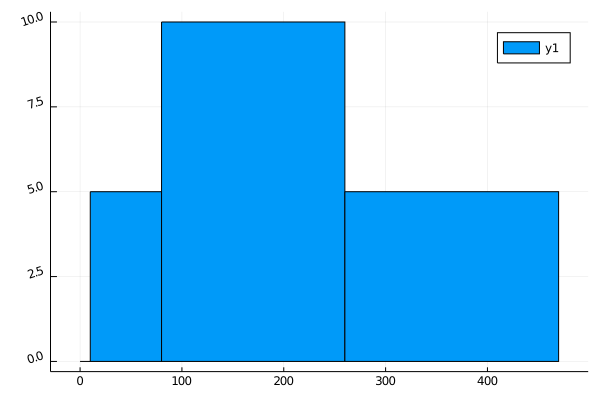

In [6]:
method = random_unif # l'algo doit renvoyer la distance en fin d'évolution
thresholds = [10, 80, 260] # les délimitations des cases où ranger les résultats
nTests = 20 # nombre de tests à effectuer

histogram_birds()

# Petits tests bêtes pour comprendre la base

In [ ]:
pop = Array{Bird}(undef, 5)

for i in eachindex(pop)
    pop[i] = Bird()
    evaluate!(pop[i])
end
println(pop)

pop2 = sort(pop, rev=true)

In [ ]:
N = ones(3,2)
println(N)
S = [5,10]
#println(N.*S)
#println(S.*N)
#println(dot(S,N))
#println(dot(N,S))
#res1 = [dot(N[:, i]) for i in 1:size(N, 2)]
#println("res1 ",res1)

res2 = reshape([N[i,:].*S for i in 1:3],3,2)
println("res2 ",res2)

x = [2.0,4.0]
P = repeat(x,1,3)
println(P')

println(P'.+N)
println(P'.+res2)

In [ ]:
list = [41,42,444,569,1,-3]
a = 0
for i in list
    println("i:",i)
    if (max(a,i)!= a)
        a = i
        println("new a:",a)
    end
end
a